In [1]:
import argparse
import os

import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from mup.coord_check import get_coord_data, plot_coord_data
from mup import MuAdam, MuSGD, get_shapes, make_base_shapes, set_base_shapes

### hyper parameter

In [2]:
batch_size = 64
test_batch_size = 128
lr = 0.01
seed = 42
# our hyper parameter
T = 1
width = 128  
depth = 4 # Does not include output and output layer
out_alpha = 1 #1/math.sqrt(width)
connect_type = "pre" # post

### prepare data

In [3]:
transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

In [4]:
transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

In [5]:
trainset = torchvision.datasets.CIFAR10(
    root='../dataset', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='../dataset', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
# Training
def train(epoch, net):
    from utils import progress_bar
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [7]:
def test(epoch, net):
    from utils import progress_bar
    best_acc = -1
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


# Set the random seed manually for reproducibility.
torch.manual_seed(seed)

### Task 1. pre or post

In [9]:
from model.resnet_mlp import ResNetMlp

In [10]:
post_config = {
    "T": 1,
    "width": 128,
    "depth": 4,
    "out_alpha": 1,  # 1/math.sqrt(width)
    "connect_type": "post"  # pre or post
}
pre_config = {
    "T": 1,
    "width": 128,
    "depth": 4,
    "out_alpha": 1,  # 1/math.sqrt(width)
    "connect_type": "pre"  # pre or post
}

In [11]:
def bulidModel(*arg,**kwargs):
    print(kwargs)
    T  = kwargs["T"]
    depth = kwargs["depth"]
    width = kwargs["width"]
    out_alpha = kwargs["out_alpha"]
    connect_type = kwargs["connect_type"]
    # width,depth,T,out_alpha, connect_type,
    return  ResNetMlp(width,depth, T,out_alpha, connect_type)

pre_mlp = bulidModel(**pre_config).cuda()
post_mlp = bulidModel(**post_config).cuda()

{'T': 1, 'width': 128, 'depth': 4, 'out_alpha': 1, 'connect_type': 'pre'}
{'T': 1, 'width': 128, 'depth': 4, 'out_alpha': 1, 'connect_type': 'post'}


In [12]:
def get_state(net):
    avg_norm = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs,hidden_state = net(inputs.view(inputs.size(0), -1))
            for k,v in hidden_state.items():
                norms = torch.norm(v, dim=1)  # 沿着第二维计算范数
                avg_norm.extend(norms.tolist())  # 转换为Python列表
    return sum(avg_norm)/len(avg_norm)

In [13]:
get_state(pre_mlp)

16.09844837678075

In [14]:
get_state(post_mlp)

16.60427702638507

In [15]:
from tqdm import tqdm

In [31]:
pre_norms = []
post_norms = []
all_widths = [128,256,512,1024,2048]
for width in tqdm(all_widths):
    pre_mlp = ResNetMlp(width=width, depth=4, T=1, out_alpha=1, connect_type="pre").cuda()
    post_mlp = ResNetMlp(width=width, depth=4, T=1, out_alpha=1, connect_type="post").cuda()
    pre_norms.append(get_state(pre_mlp))
    post_norms.append(get_state(post_mlp))

100%|██████████| 5/5 [00:17<00:00,  3.42s/it]


In [32]:
pre_norms_L = []
post_norms_L = []
depths = [4,8,12,24,48]
for depth in tqdm(depths):
    pre_mlp = ResNetMlp(width=128, depth=depth, T=1, out_alpha=1, connect_type="pre").cuda()
    post_mlp = ResNetMlp(width=128, depth=depth, T=1, out_alpha=1, connect_type="post").cuda()
    pre_norms_L.append(get_state(pre_mlp))
    post_norms_L.append(get_state(post_mlp))

100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


In [38]:
import matplotlib.pyplot as plt
import numpy as np

def draw_pic(post_values,pre_values,x_labels):
    x_positions = range(len(post_values))  

    plt.figure(figsize=(12, 6))

    plt.plot(x_positions, post_values, marker='o', linewidth=2, label='post', color='blue', markersize=8)
    plt.plot(x_positions, pre_values, marker='s', linewidth=2, label='pre', color='red', markersize=8)

    plt.xticks(x_positions, x_labels, fontsize=11)

    plt.title('Post vs Pre', fontsize=16, fontweight='bold')
    plt.xlabel('depth', fontsize=12)
    plt.ylabel('Samples Norm(avg)', fontsize=12)

    plt.legend(fontsize=12, loc='upper left')
    plt.grid(True, alpha=0.3, linestyle='--')
    #plt.tight_layout()

    # 显示图形
    plt.show()

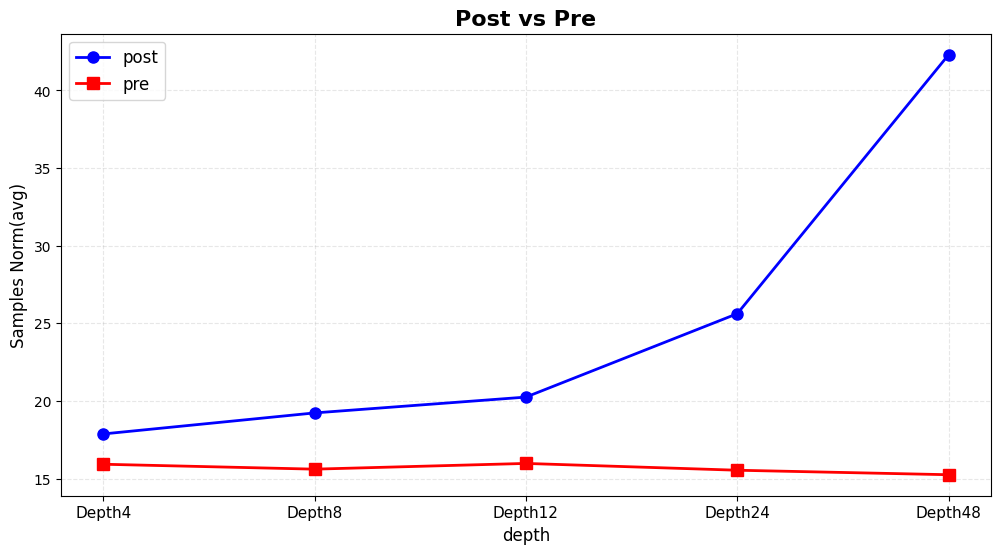

In [39]:
x_labels = ["Depth{}".format(it) for it in depths]
draw_pic(post_norms_L, pre_norms_L, x_labels)

### Task2. The impact of T(1,2,4,8)

In [ ]:
Ts = [1,2,4,8]
for T in Ts:
    break

In [ ]:
T

### Task3. Convergence test